# CSC413 Project: Toxicity Detector

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import DataLoader, TensorDataset

## Data

We will begin by downloading the data onto Google Colab from kaggle. The data is retrieved from https://www.kaggle.com/datasets/fizzbuzz/cleaned-toxic-comments

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload() # Upload kaggle.json file

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"seoulsim","key":"aeaf258f72132ae51232c7d3f11ecab3"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d fizzbuzz/cleaned-toxic-comments
! unzip cleaned-toxic-comments.zip

cleaned-toxic-comments.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cleaned-toxic-comments.zip
replace test_preprocessed.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Data Analysis and Processing
We will analyze the type and amount of data that we will work with and introduce a validation set.

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/train_preprocessed.csv')
df_test = pd.read_csv('/content/test_preprocessed.csv')

# Randomly split the train set into a 15% validation and 85% train set
df_val = df_train.sample(n=int(len(df_train) * 0.15))
df_train = df_train.drop(df_val.index)

# First few samples in the data set of each toxicity level
print(df_train.head())
print(df_train[df_train['toxic']==1.0].head())
print(df_train[df_train['threat']==1.0].head())
print(df_train[df_train['severe_toxic']==1.0].head())

                                        comment_text                id  \
0  explanation why the edits made under my userna...  0000997932d777bf   
1  d aww  he matches this background colour i m s...  000103f0d9cfb60f   
2  hey man  i m really not trying to edit war  it...  000113f07ec002fd   
3    more i can t make any real suggestions on im...  0001b41b1c6bb37e   
4  you  sir  are my hero  any chance you remember...  0001d958c54c6e35   

   identity_hate  insult  obscene    set  severe_toxic  threat  toxic  \
0            0.0     0.0      0.0  train           0.0     0.0    0.0   
1            0.0     0.0      0.0  train           0.0     0.0    0.0   
2            0.0     0.0      0.0  train           0.0     0.0    0.0   
3            0.0     0.0      0.0  train           0.0     0.0    0.0   
4            0.0     0.0      0.0  train           0.0     0.0    0.0   

   toxicity  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
                                

In [ ]:
training_samples = len(df_train)
val_samples = len(df_val)
testing_samples = len(df_test)
print(f'Train samples: {training_samples}')
print(f'Validation samples: {val_samples}')
print(f'Test samples: {testing_samples}')

Train samples: 135636
Validation samples: 23935
Test samples: 153164


Now we will tokenize and prepare the word embedding:

In [ ]:
def tokenize_text(text):
    # Check if text is not NaN
    if isinstance(text, str):
        return text.split()
    else:
        return []

def convert_indices(data, vocab):
    result = []
    for row in data:
        text = row.comment_text
        label = row.toxicity
        words = tokenize_text(text)
        indices = [vocab[word] for word in words if word in vocab]
        result.append((indices, label))
    return result

Create vocab:

In [ ]:
vocab = {}
for text in df_train['comment_text']:
    words = tokenize_text(text)
    for word in words:
        if word not in vocab:
            vocab[word] = len(vocab)
print(vocab)

# Convert data to word indices
train_data_indices = convert_indices(df_train.itertuples(index=False), vocab)
val_data_indices = convert_indices(df_val.itertuples(index=False), vocab)
test_data_indices = convert_indices(df_test.itertuples(index=False), vocab)

max_seq_length = 200
pad_sequence = nn.utils.rnn.pad_sequence

{'explanation': 0, 'why': 1, 'the': 2, 'edits': 3, 'made': 4, 'under': 5, 'my': 6, 'username': 7, 'hardcore': 8, 'metallica': 9, 'fan': 10, 'were': 11, 'reverted': 12, 'they': 13, 'weren': 14, 't': 15, 'vandalisms': 16, 'just': 17, 'closure': 18, 'on': 19, 'some': 20, 'gas': 21, 'after': 22, 'i': 23, 'voted': 24, 'at': 25, 'new': 26, 'york': 27, 'dolls': 28, 'fac': 29, 'and': 30, 'please': 31, 'don': 32, 'remove': 33, 'template': 34, 'from': 35, 'talk': 36, 'page': 37, 'since': 38, 'm': 39, 'retired': 40, 'now': 41, 'd': 42, 'aww': 43, 'he': 44, 'matches': 45, 'this': 46, 'background': 47, 'colour': 48, 'seemingly': 49, 'stuck': 50, 'with': 51, 'thanks': 52, 'january': 53, 'utc': 54, 'hey': 55, 'man': 56, 'really': 57, 'not': 58, 'trying': 59, 'to': 60, 'edit': 61, 'war': 62, 'it': 63, 's': 64, 'that': 65, 'guy': 66, 'is': 67, 'constantly': 68, 'removing': 69, 'relevant': 70, 'information': 71, 'talking': 72, 'me': 73, 'through': 74, 'instead': 75, 'of': 76, 'seems': 77, 'care': 78, 'm

In [ ]:
# The following code proves that the longest sequences are super long.
# this longest sequence will define the rest of the shapes, as
# pad_sequence pads with 0s, to the length of the longest sequence.

lengths = [len(item[0]) for item in val_data_indices]

# Sort indices based on lengths
sorted_indices = sorted(enumerate(lengths), key=lambda x: x[1], reverse=True)

# Extract the indices of the top 3 longest sequences
top3_indices = [val_data_indices[i[0]] for i in sorted_indices[:3]]

# Print the lengths of the top 3 longest sequences
print("Top 3 longest sequences:")
for indices, label in top3_indices:
    print(f"Length: {len(indices)}, Label: {label}")


# Pad sequences to a common length
train_indices_padded = pad_sequence([torch.tensor(item[0]) for item in train_data_indices], batch_first=True)
val_indices_padded = pad_sequence([torch.tensor(item[0]) for item in val_data_indices], batch_first=True)
test_indices_padded = pad_sequence([torch.tensor(item[0]) for item in test_data_indices], batch_first=True)
print(val_indices_padded.shape)
def print_indices_in_sequence(sequence):
    for index in sequence[0]:
        print(index.item())

print_indices_in_sequence(val_indices_padded)

# Convert labels to tensors
train_labels = torch.tensor([item[1] for item in train_data_indices])
val_labels = torch.tensor([item[1] for item in val_data_indices])
test_labels = torch.tensor([item[1] for item in test_data_indices])

def print_label_counts(labels):
    unique_labels, label_counts = torch.unique(labels, return_counts=True)

    print("Label Counts:")
    for label, count in zip(unique_labels, label_counts):
        print(f"Label {int(label)}: {count} samples")

print_label_counts(val_labels)

Top 3 longest sequences:
Length: 1401, Label: 5.0
Length: 1251, Label: 3.0
Length: 1250, Label: 0.0
torch.Size([23935, 1401])
17
60
86
99
487
6191
60
96
6057
60
4502
36576
6211
966
479
1126
6894
6893
611
14282
432
2998
188
96
1381
92
9854
6191
970
2954
36576
432
65
14512
740
174
8090
23
39
99
715
3872
65
6
18085
2954
14282
464
125
269
2
1674
2346
1068
159
2130
15633
2
11250
76
2864
19441
44
432
372
15
63
726
65
127
497
51
265
1419
2894
63
4176
60
46
1510
60
96
810
143
249
2
240
1862
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:

# Create TensorDataset
train_dataset = TensorDataset(train_indices_padded, train_labels)
val_dataset = TensorDataset(val_indices_padded, val_labels)
test_dataset = TensorDataset(test_indices_padded, test_labels)
print("Validation Dataset:")
print("Number of Samples:", len(val_dataset))
print("Shape Example:", val_dataset[0][0])
print("Label Example:", val_dataset[0][1])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


# Import and export GloVE embeddings
import torchtext

def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    num_words = min(len(word_index) + 1, len(embeddings_index))
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embeddings_index[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                               dim=50)

# Create an embedding matrix
embedding_dim = 50  # Use the same dimension as the GloVe embeddings
pre_trained_glove_embedding_matrix = create_embedding_matrix(vocab, glove, embedding_dim)


class LSTMToxicityModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, pre_trained_embedding_matrix = [], use_glove=False, train_glove=False):
        super(LSTMToxicityModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

        # GloVE Embedding Version
        if use_glove:
          self.embedding = nn.Embedding.from_pretrained(torch.tensor(pre_trained_embedding_matrix, dtype=torch.float), freeze=train_glove)

    def forward(self, X):
        embedded = self.embedding(X)
        lstm_out, _ = self.lstm(embedded)
        last_hidden_state = lstm_out[:, -1, :]
        output = self.fc(last_hidden_state)
        return output

Validation Dataset:
Number of Samples: 23935
Shape Example: tensor([17, 60, 86,  ...,  0,  0,  0])
Label Example: tensor(0.)


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        label_list.append(torch.tensor(label))

    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list)
    return X, t


train_dataloader = DataLoader(train_data_indices, batch_size=10, shuffle=True,
                              collate_fn=collate_batch)

In [ ]:
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model,                # an instance of an RNN LSTM model
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=1,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts)
                loss = criterion(z, labels.long())

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

In [ ]:
#RNN_LSTM = LSTMToxicityModel(len(vocab), 128, 64, 7, pre_trained_glove_embedding_matrix, False, False)
# With Glove
RNN_LSTM = LSTMToxicityModel(len(vocab), 128, 64, 7, pre_trained_glove_embedding_matrix, True, True)

1 Loss: 2.0157618522644043 Train Acc: 0.497 Val Acc: 0.502
2 Loss: 1.2887018918991089 Train Acc: 0.858 Val Acc: 0.865
3 Loss: 0.5802666544914246 Train Acc: 0.891 Val Acc: 0.899
4 Loss: 0.2654969096183777 Train Acc: 0.892 Val Acc: 0.903
5 Loss: 0.5562276840209961 Train Acc: 0.892 Val Acc: 0.904
6 Loss: 0.35564175248146057 Train Acc: 0.893 Val Acc: 0.905
7 Loss: 0.497305303812027 Train Acc: 0.893 Val Acc: 0.905
8 Loss: 0.506968080997467 Train Acc: 0.893 Val Acc: 0.906
9 Loss: 0.739788293838501 Train Acc: 0.893 Val Acc: 0.906
10 Loss: 0.5054731965065002 Train Acc: 0.893 Val Acc: 0.906
11 Loss: 0.46251797676086426 Train Acc: 0.893 Val Acc: 0.906
12 Loss: 1.1084086894989014 Train Acc: 0.893 Val Acc: 0.906
13 Loss: 0.7194467186927795 Train Acc: 0.893 Val Acc: 0.906
14 Loss: 1.1135516166687012 Train Acc: 0.893 Val Acc: 0.906
15 Loss: 0.6170061230659485 Train Acc: 0.893 Val Acc: 0.906
16 Loss: 0.5266785621643066 Train Acc: 0.893 Val Acc: 0.906
17 Loss: 0.24693100154399872 Train Acc: 0.893 Val 

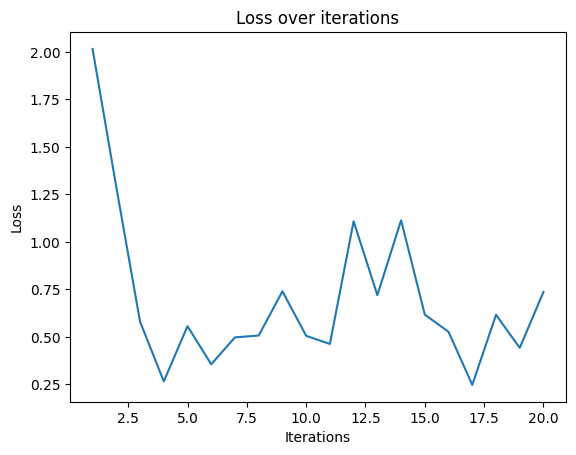

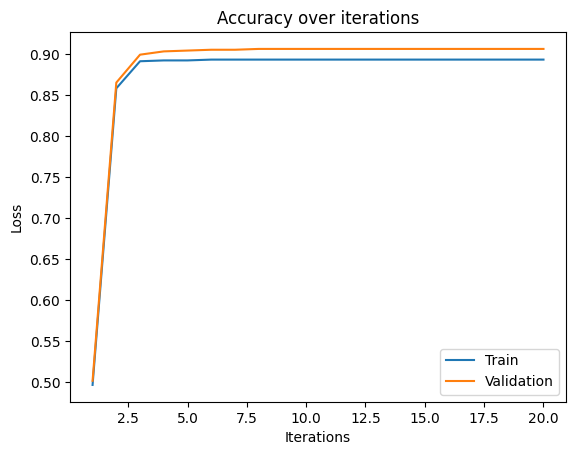

In [ ]:
train_data_indices = convert_indices(df_train.itertuples(index=False), vocab)
val_data_indices = convert_indices(df_val.itertuples(index=False), vocab)

train_model(RNN_LSTM, train_data_indices[:1000], val_data_indices[:1000], plot_every=1, learning_rate=0.01,
                batch_size=50,
                num_epochs=1)

## Confusion Matrix Analysis



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sklearn
label = "01234567"
def plot_confusion(model, data):
    data = torch.utils.data.DataLoader(data,
                                        batch_size=100,
                                        collate_fn=collate_batch,
                                        shuffle=True)
    n = 0
    ts = []
    ys = []
    model.to('cpu')
    for x, t in data:
        z = model(x)
        ts.append(t)
        ys.append(z.detach())
        print(z)
        print(t)

    cm = confusion_matrix(ts, ys)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
    plt.figure()
    disp.plot()

plot_confusion(RNN_LSTM, train_data_indices[:10])

tensor([[ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.0673,  0.5769, -0.1855, -0.1265, -0.4183, -2.9962, -3.2589],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283],
        [ 2.5391,  0.5024, -0.4522, -0.4232, -0.7673, -3.3198, -3.6283]],
       grad_fn=<AddmmBackward0>)
tensor([0., 0., 0., 4., 0., 0., 0., 0., 0., 0.])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to eith

ValueError: ignored